# Individual Data Generation Example
For the individual data generation, the probability to have a true positive label is dependant on the previous predictions for the individual. The number of positive and negative predictions defines, whether individuals move towards the positive or negative cluster. Note, that the negative label is 0 here, therefore only positive decisions have an impact on $X$.

In [1]:
import sys
import numpy as np
sys.path.append("../")

from fairensics.methods import FairDisparateImpact, AccurateDisparateImpact

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from aif360.algorithms.inprocessing import PrejudiceRemover

from long_term_fairness.ltf_plot import LongTermFairnessPlot
from long_term_fairness.ltf_data.individual_data_generator import DataGenerator as IndDataGen
from long_term_fairness.ltf_aif.longterm_aif import AifLongTermMetric, AifLongTermPrediction

Import error: No module named 'tensorflow'


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The helper class is necessary to use sklearn with the ltf framework.
class CLF:
    def __init__(self, clf=LogisticRegression()):
        self.c = clf
    def predict(self, X, X_s):
        return self.c.predict(X)
    def fit(self, X, X_s, y):
        self.c.fit(X, y)   

## 1. Unconstrained Example
First, an unconstrained classifier is trained. In this case a linear support vector machine. In the first generation, both baseline and true data will be identical.

Because the SVM is unconstrained, it perfectly distinguishes the data points. Hence, the number of positive and negative labels will not change through time in the true data. 

In the baseline data, the whole negative group will slowly move towards the positive cluster.

In [26]:
# The data generator.
generator = IndDataGen(mean_pos=[0, 1],
                       mean_neg=[8, 9],
                       num_positive_label=50,
                       num_negative_label=50,
                       discrimination_factor=.9)

In [32]:
# The AIF metric for long term prediction.
metric = AifLongTermMetric()

In [6]:
# The clf.
clf = CLF()

In [7]:
# The ltf plot generator.
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 12], y_lim=[-1, 13])

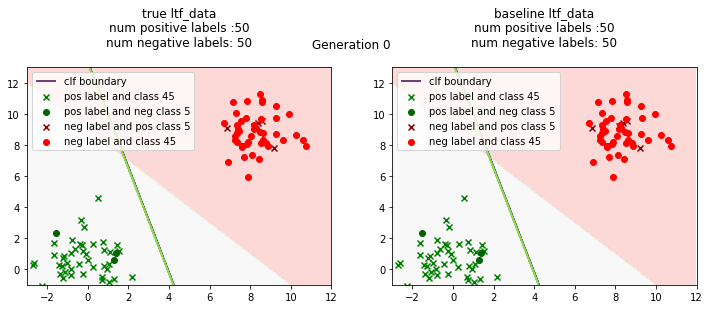

In [8]:
# Initialize the data and plot the first generation.
l.init_data()
l.plot_generation()

On initialization, both left and right figure are the same.

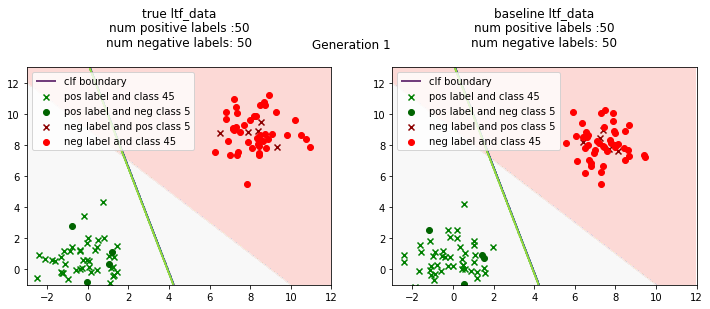

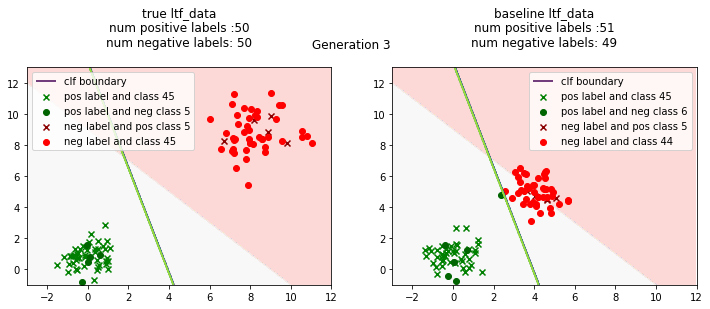

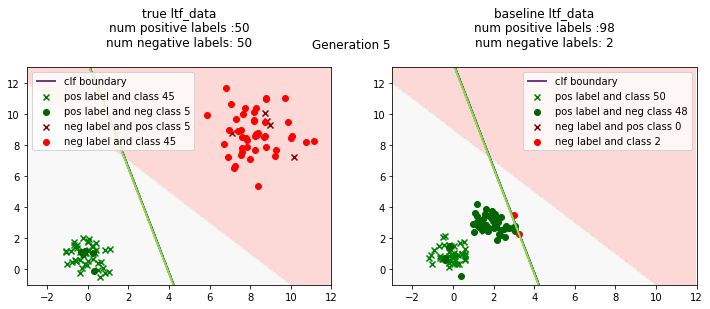

In [9]:
# Run 6 generations and plot overy second step to visualize the points moving towards the positive cluster.
for i in range(6):
    l.run_generation()
    l.run_baseline_generation()
    
    if i % 2 == 0:
        l.plot_generation()

After 6 iterations the proportions in the true data (left column) did not change. In the baseline data (right column), all points have a true positive label now.

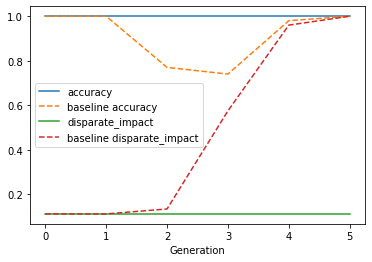

In [10]:
# Plot the metrics for the six generations.
l.plot_ltf(metric._metrics)

In the true data, accuracy and disparate impact are constant through all generations. In the baseline case, disparate impact improves constantly and the accuracy drops for a short period of three generations. The accuracy decrease is for instance visible in the plot of generation 3. Some individuals reach the data generating boundary (the border between red and white area) but are labeled negative because the learned boundary (green line) does not perfectly match the true boundary.

Although the decision function learns to separate the data perfectly it does not unleash the full potential of all individuals. It keeps the initial discrimination in the data constant.

## 2. Constrained Example 
The unconstrained example showed, that a perfect decision boundary might not unleash the full potential of each individual. This section shows, that a constrained decision function might be better, but still does not unleash the full potential assuming the underlining setting of data generation.

In [22]:
# Fair artificial decision rule.
class FairCLF:
    def predict(self, X, X_s):
        pred = [5, -12] @ X.T + 50
        
        pred[pred>0] = 1
        pred[pred<0] = 0
        
        return np.sign(pred)
    def fit(self, X, X_s, y):
        pass

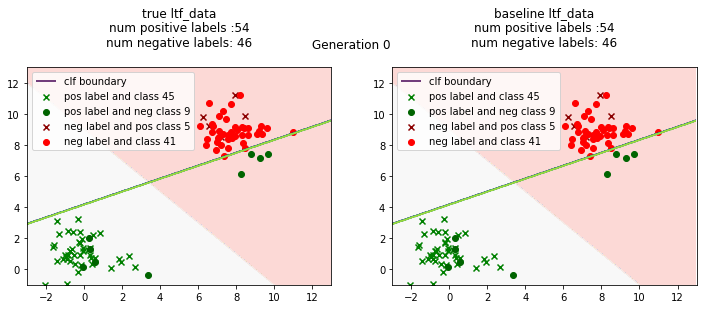

In [29]:
# Initilaize experiment and plot the first generation.
clf = FairCLF()
# clf = AifLongTermPrediction(AccurateDisparateImpact())

l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 13], y_lim=[-1, 13])

l.init_data()
l.plot_generation()

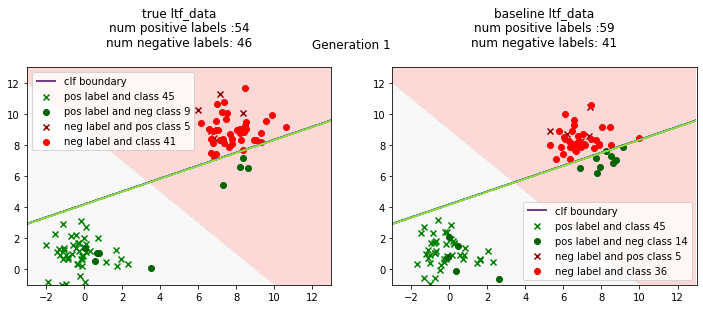

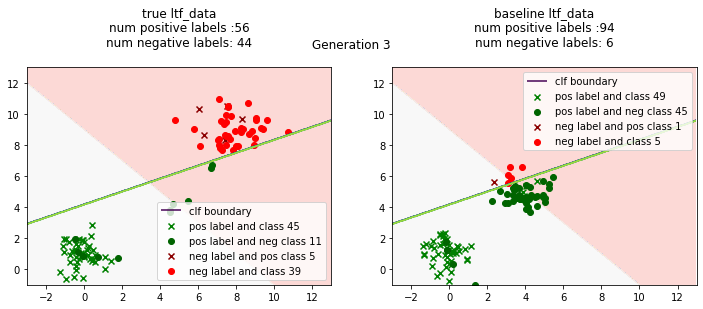

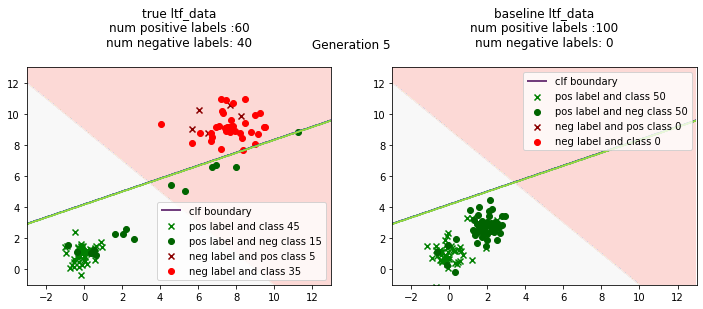

In [33]:
# Run 6 generations with the constraiiend classifier and plot data after every second iteration.
for i in range(6):
    l.run_generation()
    l.run_baseline_generation()
    if i % 2 == 0:
        l.plot_generation()

Again, all individuals are labeled positive after 6 generations in the baseline case. In the true data, individuals with a positive prediction move towards the positive cluster. However, because of the location of the decision boundary, points close to it can randomly jumpy between the sides.

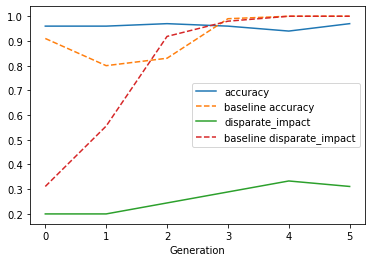

In [34]:
# Plot metrics over the 6 generations.
l.plot_ltf(metric._metrics)

The baseline data reached perfect fairness after 6 generations, while the true data is still improving. Note that the true data is still improving, because of the variance between time steps. There is a small chance that individuals will cross the decision boundary in each generation. Hence, in the (very) long term all individuals will be labeled positive.

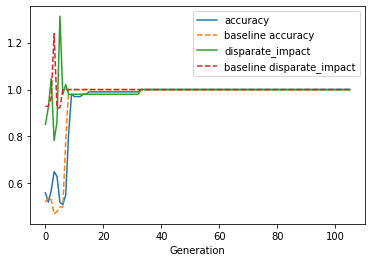

In [15]:
# Repeat the simulation for another 1000 generations.
l.run(100)
l.plot_ltf(metric._metrics)

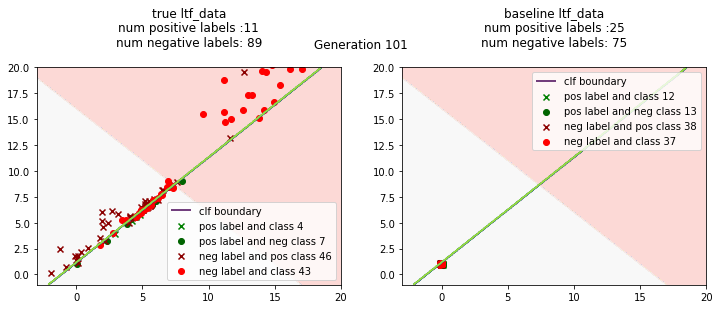

In [21]:
# Plot the data after 100 generations.
l.plot_generation()

After 1000 generations, fairness continues to improve for the true data, while is is already perfect in the baseline data.

## 2.1 Constrained Example with Lower Variance
The setting for this example is the same as before except that the local variance is smaller now (the local variance is the deviation of the features $x_i ^{(t)}$ from the previous features $x_i ^{(t-1)}$ of individual $i$). 

Hence, the probability for individuals to randomly cross the decision boundary is much slower now and only the individuals who were lucky in the first generation will benefit from this decision rule.

In [17]:
# New generator with smaller local variance.
generator = IndDataGen(mean_pos=[0, 1],
                       mean_neg=[15, 16],
                       cov_neg= [[6, 0],[0, 7]], 
                       num_positive_label=50,
                       num_negative_label=50,
                       discrimination_factor=.9,
                       local_variance=[[0.001, 0], [0, 0.001]])

l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 20], y_lim=[-1, 20])

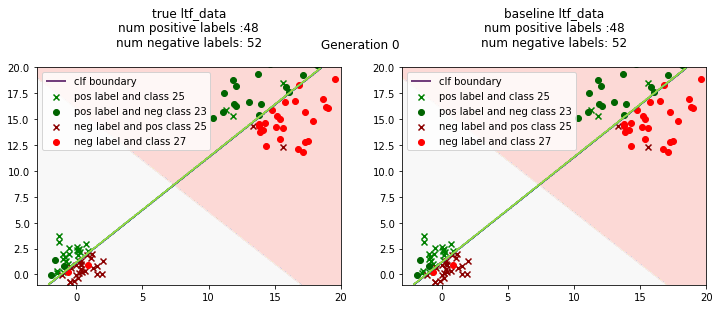

In [18]:
# Plot the initial data.
l.init_data()
l.plot_generation()

Only two individuals with a negative label are now predicted with a positive label (green circles in the red colored area).

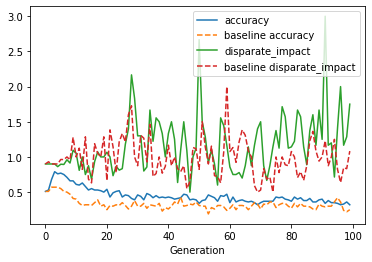

In [19]:
# Run 100 generations with the lower variance data.
l.run(100)
l.plot_ltf(metric._metrics)

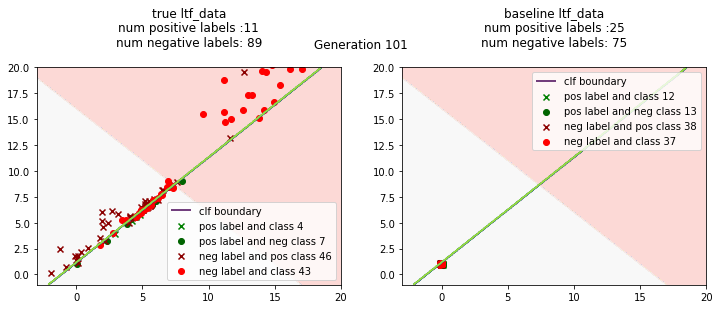

In [20]:
# Plot the data points after 100 generations with lower variance.
l.plot_generation()

In the lower variance example, individuals do not cross the decision boundary and are therefore never move towards the positive center. Only those individuals who were lucky in the first generation have moved to the positive cluster.

Note that there is a large concentration at the center of the positive cluster now due the small local variance.

### 2.1.1 Conclusion
...